In [1]:
!pip install tensorflow==2.3.0
!pip install gymnasium
!pip install keras
!pip install keras-rl2

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.3.0


In [2]:
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import math
from scipy.signal import chirp, spectrogram
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten

from keras import __version__
tf.keras.__version__ = __version__

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [3]:
class RoadEnv():
    def __init__(self):
        self.m = 10
        self.n0 = 0.1
        self.W = 2
        self.Gq_n0 = 256e-6
        self.nmid = np.linspace(0.011+(2.83-0.011)/self.m/2,2.83-(2.83-0.011)/self.m/2,self.m)
        self.delta_n = (2.83-0.011)/self.m * np.ones(self.m)
        self.Gq = np.zeros(self.m)
        
        for i in range(self.m):
            self.Gq[i] = self.Gq_n0 * (self.nmid[i] / self.n0) ** (-self.W)
        
        self.phi = np.random.rand(self.m) * 2 * np.pi
    
    def height(self, x):
        z = 0
        for i in range(self.m):
            z += np.sqrt(2 * self.Gq[i] * self.delta_n[i]) * np.sin(2 * np.pi * self.nmid[i] * x + self.phi[i])
    
        return z

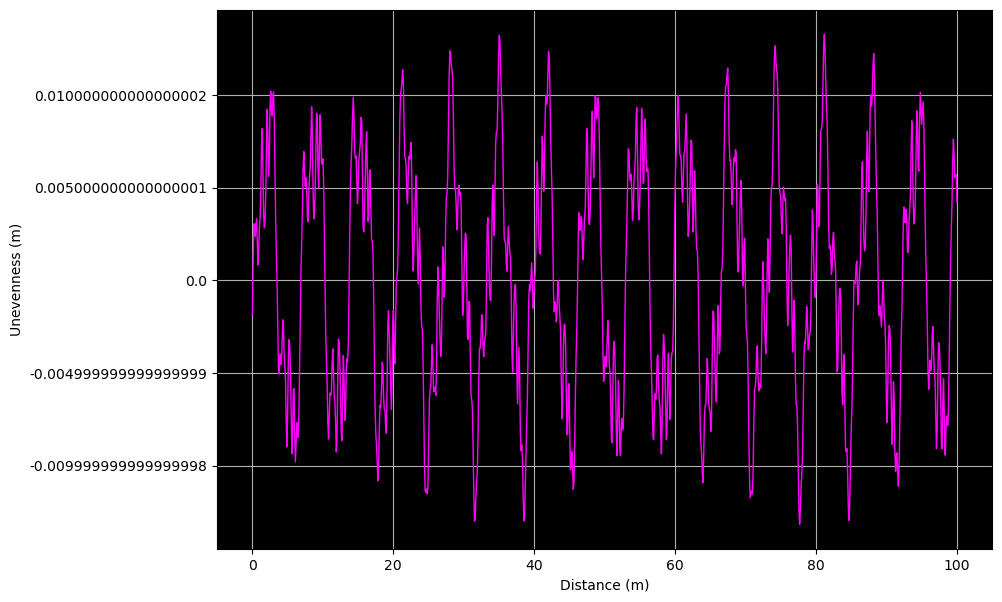

In [4]:
road = RoadEnv()
x_final = 100
x_steps = 1000
L = np.linspace(0, x_final, num=x_steps)
Z = np.zeros(x_steps)
for j in range(x_steps):
    Z[j] = road.height(L[j])

%matplotlib inline
plt.figure(figsize=(10, 7), facecolor="white")

plt.plot(L, Z, linewidth=1, color="magenta")
text_color = "black"
ax = plt.gca()
ax.set_facecolor("black")
plt.grid()
plt.xlabel("Distance (m)", color=text_color, fontsize=10)
plt.ylabel("Unevenness (m)", color=text_color, fontsize=10)
yNumFmt = mticker.StrMethodFormatter("{x:,}")
ax.yaxis.set_major_formatter(yNumFmt)
ax.tick_params(axis="x", colors=text_color)
ax.tick_params(axis="y", colors=text_color)
plt.show()    

In [5]:
class QuarterCarSuspEnv(Env):
        
    def __init__(self):
        self.ms = 450.    # sprung mass (kg)
        self.mt = 50.     # unsprung mass (kg)
        self.ks = 27000.  # suspension stiffness (N/m)
        self.cs = 100.    # suspension damping (N.s/m)
        self.cs_passive = 1500.    # passive suspension damping - for comparison (N.s/m)
        self.kt = 243000. # tire stiffness (N/m)
        
        self.vveh = 30. * 0.277778 # vehicle speed (m/s)
        self.max_susp_travel = 0.1 # maximum allowed suspension travel - terminate episode

        self.road = RoadEnv()
        
        self.tau = 0.001  # solver time step (s)
        self.force_mag = 2000 # active damper force max (N)
        self.reward_wts = [0.7, 0.1, 0.1, 0.1]    # reward weight on (xs''^2,(xt-xr_^2)^2,(xs-xt)^2,fa^2)
        
        self.action_space = Box(-self.force_mag, self.force_mag)
        self.observation_space = Box(-np.ones(4, dtype=np.float32), np.ones(4, dtype=np.float32))
        
        # starting point
        self.X = np.array([[0], 
                           [0], 
                           [0], 
                           [0]], dtype=np.float32)
        self.timer = 0.

        # model matrix
        self.A = np.matrix([[0, 0, 1, 0],
                            [0, 0, 0, 1],
                            [-self.ks/self.ms, self.ks/self.ms, self.cs/self.ms, -self.cs/self.ms],
                            [self.ks/self.mt, -(self.ks+self.kt)/self.mt, self.cs/self.mt, -self.cs/self.mt]], dtype=np.float32,)
        self.B = np.matrix([[0],
                            [0],
                            [-1/self.ms],
                            [1/self.mt]], dtype=np.float32,)
        self.G = np.matrix([[0],
                            [0],
                            [0],
                            [self.kt/self.mt]], dtype=np.float32,)
        self.Cz= np.matrix([[-self.ks/self.ms, self.ks/self.ms, -self.cs/self.ms, self.cs/self.ms],
                            [0, 1, 0, 0],
                            [1,-1, 0, 0]], dtype=np.float32,)
        self.Dz= np.matrix([[-1/self.ms],
                            [0],
                            [0]], dtype=np.float32,)
        self.Tz= np.matrix([[0],
                            [-1],
                            [0]], dtype=np.float32,)
        self.Cy= np.matrix([[-self.ks/self.ms, self.ks/self.ms, -self.cs/self.ms, self.cs/self.ms],
                            [0, 0, 1, 0],
                            [0, 0, 1,-1],
                            [1,-1, 0, 0]], dtype=np.float32,)
        self.Dy= np.matrix([[-1/self.ms],
                            [0],
                            [0],
                            [0]], dtype=np.float32,)

    def step(self, action):
        t = self.timer
        xr = self.road.height(self.vveh * t)
                
        U = np.array([np.float32(action)]).reshape(1,1)
        W = np.array([np.float32(xr)]).reshape(1,1)
        dX= np.matmul(self.A, self.X) + np.matmul(self.B,U) + np.matmul(self.G,W) # state variables: (xs, xt, xs', xt')
        Z = np.matmul(self.Cz,self.X) + np.matmul(self.Dz,U) + np.matmul(self.Tz,W) # controlled output: (xs'', xt-xr, xs-xt) 
        Y = np.matmul(self.Cy,self.X) + np.matmul(self.Dy,U) # observation state: (xs'', xs', xs'-xt', xs-xt)
        
        self.X = self.X + self.tau * dX            
        self.timer += self.tau

        state = [Y[0,0], Y[1,0], Y[2,0], Y[3,0]]

        reward = -self.reward_wts[3] * (U[0]/2000)**2 - 500 * (np.absolute(self.X[0,0]-self.X[1,0]) > self.max_susp_travel)
        for i in range(3):
            reward += -self.reward_wts[i] * Z[0,0]**2

        if np.absolute(self.X[0,0]-self.X[1,0]) > self.max_susp_travel:
            done = True
        else:
            done = False

        #if self.timer > 100:
            #done = True
            
        info = {}

        return state, reward, done, info
    
    def reset(self):
        state = np.array([0, 0, 0, 0],dtype=np.float32)
        self.X = np.array([[0], [0], [0], [0]],dtype=np.float32)
        self.timer = 0.
        
        return state
    
    def render(self):
        pass

In [6]:
env = QuarterCarSuspEnv()

state_size = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: 4
Number of actions: 1


In [7]:
env.action_space.sample()

array([1934.8965], dtype=float32)

In [8]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    
    while not done:
        env.render()
        action = env.action_space.sample()[0]
        n_state, reward, done, info = env.step(action)
        score += reward
    
    print('Episode:{} Score:{}'.format(episode,score))

Episode:1 Score:[-10696.079]
Episode:2 Score:[-11978.965]
Episode:3 Score:[-11134.835]
Episode:4 Score:[-9179.428]
Episode:5 Score:[-8964.646]
Episode:6 Score:[-10958.62]
Episode:7 Score:[-10864.898]
Episode:8 Score:[-8938.518]
Episode:9 Score:[-10853.027]
Episode:10 Score:[-8992.995]


In [9]:
def build_model(states,actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, states)))
    model.add(Dense(units=100, activation='relu'))            
    model.add(Dense(units=100, activation='relu'))            
    model.add(Dense(units=actions, activation='linear'))
    
    return model

In [10]:
#del model

In [11]:
model = build_model(state_size,num_actions)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,701
Trainable params: 10,701
Non-trainable params: 0
_________________________________________________________________


In [13]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=5000000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=1000)
    return dqn

In [14]:
dqn = build_agent(model, num_actions)

In [15]:
dqn.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=['mae'])

In [16]:
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
  182/10000 [..............................] - ETA: 8s - reward: -0.5360 

C:\Users\gzjpjy\AppData\Roaming\Python\Python310\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  991/10000 [=>............................] - ETA: 7s - reward: -5.1509

AssertionError: 

In [ ]:
obs = env.reset()
print('Observation Shape:',obs.shape)
print('Model Input Shape:',np.reshape(obs, [1,1,state_size]).shape)
action = dqn.model.predict(np.reshape(obs, [1,1,state_size]))
print('Model Output Shape:',action.shape)
print(action)

In [ ]:
done = False
state = env.reset()
all_states = []
all_actions = []
rewards = 0.
t = 0.
while not done:
    action = dqn.model.predict(np.reshape(state, [1,1,state_size]))
    state, reward, done, _ = env.step(action)
    all_states.append(state)
    all_actions.append(action)
    rewards += reward
    print(f"\rSimulation Time: {t:.3f}", end="")
    t += 0.001

#print(len(all_states))

all_states_stacked = np.vstack(all_states)
all_actions_stacked = np.vstack(all_actions)
tt = np.linspace(0., t, num=all_states_stacked.shape[0])
print(f"\nTotal Reward: {rewards}")

In [ ]:
%matplotlib inline

plt.figure(figsize=(10, 7), facecolor="white")

plt.plot(tt, all_actions_stacked, linewidth=1, color="magenta") 
    
text_color = "black"

ax = plt.gca()
ax.set_facecolor("black")
plt.grid()
plt.xlabel("Time (s)", color=text_color, fontsize=10)
plt.ylabel("Action Force (N)", color=text_color, fontsize=10)
yNumFmt = mticker.StrMethodFormatter("{x:,}")
ax.yaxis.set_major_formatter(yNumFmt)
ax.tick_params(axis="x", colors=text_color)
ax.tick_params(axis="y", colors=text_color)
plt.show()

In [ ]:
done = False
state = env.reset()
all_states0 = []
all_actions0 = []
rewards0 = 0.
t = 0.
while not done:
    state = np.expand_dims(state, axis=0)
    action = 0 # zero active force
    state, reward, done, _ = env.step(action)
    all_states0.append(state)
    all_actions0.append(action)
    rewards0 += reward
    print(f"\rSimulation Time: {t:.3f}", end="")
    t += 0.001

all_states_stacked0 = np.vstack(all_states0)
tt0 = np.around(np.linspace(0., t, num=all_states_stacked0.shape[0]),3)
print(f"\nTotal Reward: {rewards0}")

In [ ]:
%matplotlib inline

plt.figure(figsize=(10, 7), facecolor="white")

plt.plot(tt, all_states_stacked[:,3], linewidth=1, color="magenta")
plt.plot(tt0, all_states_stacked0[:,3], linewidth=1, color="cyan", linestyle='dashed')

text_color = "black"

ax = plt.gca()
ax.set_facecolor("black")
plt.grid()
plt.xlabel("Time (s)", color=text_color, fontsize=10)
plt.ylabel("Susp Travel (m)", color=text_color, fontsize=10)
yNumFmt = mticker.StrMethodFormatter("{x:,}")
ax.yaxis.set_major_formatter(yNumFmt)
ax.tick_params(axis="x", colors=text_color)
ax.tick_params(axis="y", colors=text_color)
plt.legend(["active control", "no control"], loc="lower left")
plt.show()

In [ ]:
plt.figure(figsize=(10, 7), facecolor="white")

plt.plot(1000.*all_states_stacked[:,2], all_actions_stacked, linewidth=1, color="cyan")
    
text_color = "black"

ax = plt.gca()
ax.set_facecolor("black")
plt.grid()
plt.xlabel("Damper Velocity (mm/s)", color=text_color, fontsize=10)
plt.ylabel("Active Force (N)", color=text_color, fontsize=10)
yNumFmt = mticker.StrMethodFormatter("{x:,}")
ax.yaxis.set_major_formatter(yNumFmt)
ax.tick_params(axis="x", colors=text_color)
ax.tick_params(axis="y", colors=text_color)
plt.show()